Model


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, ReLU, GlobalAveragePooling2D, Add
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D, MaxPool2D
from tensorflow import keras
import numpy as np

tf.config.experimental_run_functions_eagerly(True)

class ResnetBlock(tf.keras.Model):
    

    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

      
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(tf.keras.Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
model = ResNet18(2)
model.build(input_shape = (None,2,98,1))
model.compile(optimizer = "adam",loss='binary_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple              

Data Loading

In [4]:
from sklearn.model_selection import train_test_split

X = np.load('/content/(N_W)X_Data.npy',allow_pickle=True)
Y = np.load('/content/(N_W)Y_Data.npy',allow_pickle=True)
X_train, X_test, y_train , y_test  = train_test_split(X, Y, test_size = 0.30, random_state = 150, shuffle=True)


In [5]:
X_train = np.asarray(X_train).astype('float32')
X_train = tf.reshape(tf.constant(X_train), [X_train.shape[0],2,98, 1])
y_train = tf.constant(y_train)
y_train = y_train 
y_train = tf.one_hot(y_train, depth = 2)
y_train = np.reshape(y_train,(8463,2))
y_train.shape

y_test = tf.constant(y_test)
y_test = y_test 
y_test = tf.one_hot(y_test, depth = 2)
y_test = np.reshape(y_test,(3627,2))
y_train.shape

(8463, 2)

In [6]:
y_test.shape

(3627, 2)

In [7]:
X_test.shape

(3627, 2, 98)

Training

In [8]:
model = model.fit(X_train,y_train, epochs = 75,batch_size = 64)

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


133/133 [==============================] - 44s 269ms/step - loss: 0.3433 - accuracy: 0.8564
Epoch 2/100
133/133 [==============================] - 36s 274ms/step - loss: 0.2258 - accuracy: 0.9078
Epoch 3/100
133/133 [==============================] - 36s 271ms/step - loss: 0.1942 - accuracy: 0.9239
Epoch 4/100
133/133 [==============================] - 35s 265ms/step - loss: 0.1782 - accuracy: 0.9293
Epoch 5/100
133/133 [==============================] - 38s 290ms/step - loss: 0.1638 - accuracy: 0.9378
Epoch 6/100
133/133 [==============================] - 36s 268ms/step - loss: 0.1471 - accuracy: 0.9453
Epoch 7/100
133/133 [==============================] - 36s 271ms/step - loss: 0.1308 - accuracy: 0.9488
Epoch 8/100
133/133 [==============================] - 36s 269ms/step - loss: 0.1319 - accuracy: 0.9503
Epoch 9/100
133/133 [==============================] - 35s 267ms/step - loss: 0.1124 - accuracy: 0.9591
Epoch 10/100
133/133 [==============================] - 48s 364ms/step - los

KeyboardInterrupt: ignored

Testing

In [10]:
#X_test = np.load('/content/X_test.npy',allow_pickle=True)
#Y_test = np.load('/content/Y_test.npy',allow_pickle=True)


X_test = np.asarray(X_test).astype('float32')
X_test = tf.reshape(tf.constant(X_test), [X_test.shape[0],2,98, 1])


In [11]:
model.evaluate(X_test,y_test)

114/114 [==============================] - 5s 40ms/step - loss: 0.2584 - accuracy: 0.9382


[0.25840941071510315, 0.9382409453392029]

In [24]:
from sklearn.metrics import accuracy_score

print("Accuracy Score = ", accuracy_score(YY_test, YY_predict))

Accuracy Score =  0.938240970499035


In [15]:
model.save('/content/Binary_ResNet')

In [13]:
import torch

model = tf.keras.models.load_model('/content/sample_data')

Evaluation

In [20]:
Predict = model.predict(X_test)

114/114 [==============================] - 1s 7ms/step


In [21]:
YY = np.array(y_test)
YY_test = np.argmax(YY,axis = 1)

YY_predict = np.argmax(Predict,axis = 1)
YY_test = np.argmax(YY,axis = 1)

YY_predict = np.argmax(Predict,axis = 1)

In [22]:
YY_predict

array([0, 1, 0, ..., 0, 0, 1])

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(YY_test, YY_predict)

cm

array([[2268,  156],
       [  68, 1135]])

In [26]:
import pandas as pd


def print_confusion_matrix(confusion_matrix, class_names, figsize = (8,8),fontsize=14, normalize=True):
     
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt= fmt)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

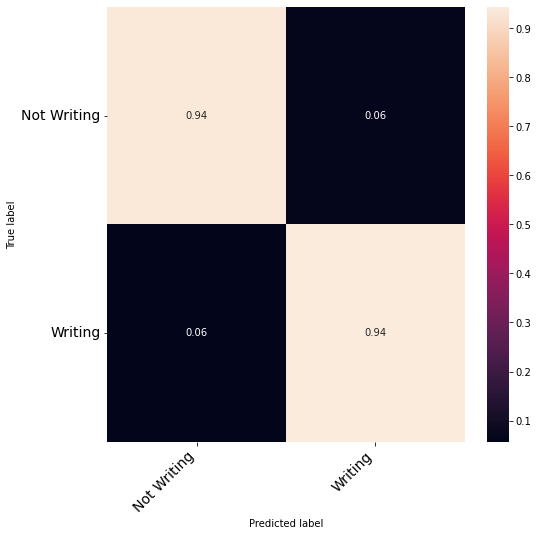

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A',
 #                  'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
  #                 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
   #                'X', 'Y', 'Z']


#class_names = ['0,O,o','1,I,i,l ','2,Z,z','3','4','5,S,s','6,G','7','8','9,a,g,q','A',
 #                  'B', 'C,c', 'D,P,p,b', 'E,e', 'F,f', 'H,h', 'J,j ', 'K,k', 'L',
  #                 'M,m', 'N,n', 'Q','R','T,t', 'U,V,u,v', 'W,w','X,x', 'Y,y', 'd'] 

#class_names = ['0','1','2','3','4','5','6','7','8','9','A',
                # 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                 # 'M', 'N', 'O', 'P', 'Q', 'R', 'S','T', 'U', 'V', 'W',
                 #'X', 'Y', 'Z','a',
                 #'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                 # 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
                 # 'x', 'y', 'z'] 


class_names = ['Not Writing','Writing']                   
print_confusion_matrix(cm, class_names)
plt.savefig('Confusion_Matix_.png', dpi=300)

In [30]:
from sklearn.metrics import classification_report

#report = classification_report(Y_test, preds,target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A',
 #                  'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
  #                 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
   #                'X', 'Y', 'Z'])

#report = classification_report(YY_test, YY_predict,target_names=['0,O,o','1,I,i,l ','2,Z,z','3','4','5,S,s','6,G','7','8','9,a,g,q','A',
 #                  'B', 'C,c', 'D,P,p,b', 'E,e', 'F,f', 'H,h', 'J,j ', 'K,k', 'L',
  #                 'M,m', 'N,n', 'Q','R','T,t', 'U,V,u,v', 'W,w','X,x', 'Y,y', 'd']) 

#report = classification_report(YY_test, YY_predict,target_names= ['0','1','2','3','4','5','6','7','8','9','A',
 #                'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
  #               'M', 'N', 'O', 'P', 'Q', 'R', 'S','T', 'U', 'V', 'W',
   #               'X', 'Y', 'Z','a',
    #             'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
     #             'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
      #            'x', 'y', 'z']) 


report = classification_report(YY_test, YY_predict,target_names= ['Not Writing','Writing'])
print(report)

              precision    recall  f1-score   support

 Not Writing       0.97      0.94      0.95      2424
     Writing       0.88      0.94      0.91      1203

    accuracy                           0.94      3627
   macro avg       0.93      0.94      0.93      3627
weighted avg       0.94      0.94      0.94      3627



In [ ]:
%%capture cap --no-stderr
print(report)

In [ ]:
with open('Classification_Report.txt', 'w') as f:
    f.write(cap.stdout)

In [31]:
from collections import Counter


correct = [pred == true for pred, true in zip(YY_predict, YY_test)]
correct = np.array(correct).flatten()
print(Counter(correct))

Counter({True: 3403, False: 224})
